In [24]:
from PIL import Image
from datasets import load_dataset, Image as HFImage, Dataset
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from trl import DPOTrainer
from trl import DPOConfig
from PIL import Image, ImageOps

In [25]:
dataset_id = "HuggingFaceH4/rlaif-v_formatted"
train_dataset, test_dataset = load_dataset(dataset_id, split=["train[:5%]", "test[:1%]"])

In [38]:
def ensure_rgb(example):
    # Convert the image to RGB if it's not already
    image = example["images"][0]
    if isinstance(image, Image.Image):
        if image.mode != "RGB":
            image = image.convert("RGB")
        example["images"] = [image]
    return example


# Apply the transformation to the dataset (change num_proc depending on the available compute)
train_dataset = train_dataset.map(ensure_rgb, num_proc=8)
test_dataset = test_dataset.map(ensure_rgb, num_proc=8)

Map (num_proc=8):   0%|          | 0/3949 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/42 [00:00<?, ? examples/s]

In [39]:
train_dataset[5]

{'chosen': [{'content': [{'text': 'The question seems to be asking about the positioning of a white food item in relation to the meat on the right side of the plate. However, there is no white food item clearly visible to the right of the meat on the right side of the plate in the image provided. The only white food items present are the rice and beans, which are located more centrally on the plate, not to the right of the meat. Therefore, based on the visual information available, it cannot be confirmed that there is a white food item to the right of the meat on the right side of the plate.',
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'The question seems to be based on a misunderstanding. There is no white food to the right of the meat on the right side of the plate. The white food is actually rice, which is positioned to the left of the meat and not to the right. The meat in question appears to be the pork chop or pork belly that is on the ri

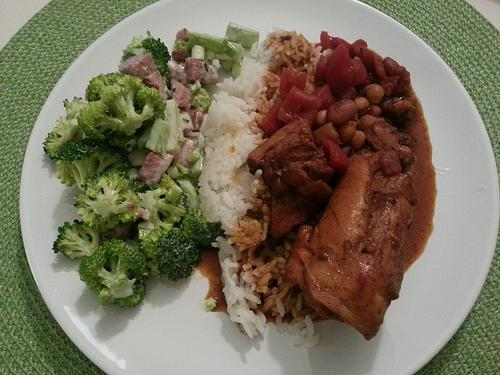

In [42]:
train_dataset[5]["images"][0]

In [43]:
MODEL_ID = "NCSOFT/VARCO-VISION-2.0-14B"

In [49]:
processor = AutoProcessor.from_pretrained(MODEL_ID)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [44]:
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map=None,                # ← DeepSpeed/Accelerate가 배치
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [45]:
ref_model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map=None,                # ← DeepSpeed/Accelerate가 배치
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [50]:
training_args = DPOConfig(
    loss_type=["sigmoid", "bco_pair", "sft"],  # Loss types to combine, as used in the MPO paper
    loss_weights=[0.8, 0.2, 1.0],  # Corresponding weights, as used in the MPO paper
    bf16=True,
    gradient_checkpointing=True,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    dataset_num_proc=1,  # tokenization will use 1 processes
    dataloader_num_workers=8,  # data loading will use 8 workers
    logging_steps=10,
    save_strategy="steps",
    save_steps=10,
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",
)

In [51]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model=model,
    ref_model=ref_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=processor,
)

Applying chat template to train dataset:   0%|          | 0/3949 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3949 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

[2025-08-28 16:21:16,346] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/eoeldroal/miniconda3/envs/Culture/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/eoeldroal/miniconda3/envs/Culture/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/eoeldroal/miniconda3/envs/Culture/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/eoeldroal/miniconda3/envs/Culture/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/eoeldroal/miniconda3/envs/Culture/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/eoeldroal/miniconda3/envs/Culture/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLI

[2025-08-28 16:21:17,548] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [52]:
trainer.train()

wandb: Currently logged in as: eoeldroal (eoeldroal-sogang-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 6 has a total capacity of 79.25 GiB of which 43.19 MiB is free. Process 1695287 has 70.12 GiB memory in use. Including non-PyTorch memory, this process has 9.07 GiB memory in use. Of the allocated memory 7.93 GiB is allocated by PyTorch, and 92.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)